# K-means classification — Step-by-step
This notebook demonstrates K-means clustering using three distance metrics: **Euclidean**, **Manhattan**, and **Cosine**.
Follow the cells below step-by-step: data creation, algorithm implementation, running experiments, and visual comparison.

In [26]:
# Cell 2: Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from collections import Counter
%matplotlib inline

## Distance Metrics Explained

Three distance metrics used in K-means clustering:

1. **Euclidean Distance**: Straight-line distance between points in space. Formula: $ d(p,q) = \sqrt{\sum_i (p_i - q_i)^2} $
   - Most intuitive and widely used.
   - Works well for continuous, low-to-moderate dimensional data.

2. **Manhattan Distance (L1)**: Sum of absolute differences along each axis. Formula: $ d(p,q) = \sum_i |p_i - q_i| $
   - Also called "taxicab distance" (like navigating city blocks).
   - Often works better for axis-aligned or sparse data.

3. **Cosine Distance**: Based on the angle between vectors (ignores magnitude). Formula: $ d(p,q) = 1 - \frac{p \cdot q}{||p|| \cdot ||q||} $
   - Measures directional similarity (0=same direction, 1=opposite).
   - Ideal for text/sparse high-dimensional data (e.g., TF-IDF vectors).

**What is ARI (Adjusted Rand Index)?**
- Measures agreement between two cluster assignments (0 to 1).
- ARI = 1: perfect agreement.
- ARI = 0: random agreement.
- ARI < 0: worse than random.
- Compares the predicted clusters with true labels, accounting for chance agreement.

## Pictorial illustration of Euclidean, Manhattan and Cosine
Small diagrams below visualize how the three distances measure similarity: Euclidean is the straight-line gap, Manhattan sums axis-aligned steps, and Cosine depends on the angle between vectors.

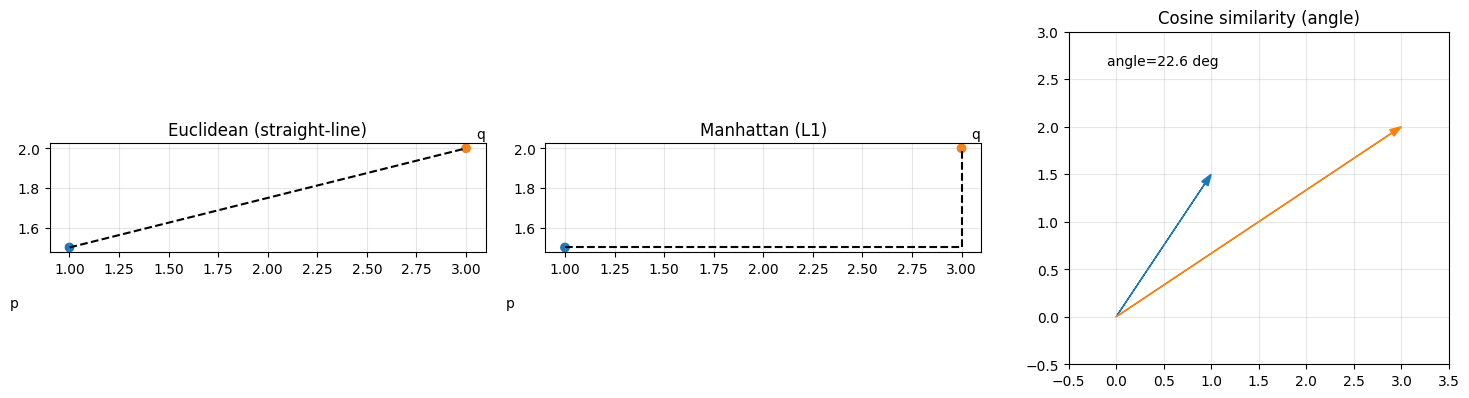

In [27]:
# Pictorial illustrations of the three distance metrics
import matplotlib.patches as patches

# Two example points
p = np.array([1.0, 1.5])
q = np.array([3.0, 2.0])

fig, axs = plt.subplots(1, 3, figsize=(15,4))
# Euclidean
axs[0].scatter([p[0], q[0]], [p[1], q[1]], c=['C0','C1'])
axs[0].plot([p[0], q[0]], [p[1], q[1]], 'k--')
axs[0].annotate('p', xy=(p[0], p[1]), xytext=(p[0]-0.3, p[1]-0.3))
axs[0].annotate('q', xy=(q[0], q[1]), xytext=(q[0]+0.05, q[1]+0.05))
axs[0].set_title('Euclidean (straight-line)')
axs[0].set_aspect('equal', adjustable='box')

# Manhattan: show L-shaped path
axs[1].scatter([p[0], q[0]], [p[1], q[1]], c=['C0','C1'])
# L-path: go horizontally then vertically
axs[1].plot([p[0], q[0]], [p[1], p[1]], 'k--')
axs[1].plot([q[0], q[0]], [p[1], q[1]], 'k--')
axs[1].annotate('p', xy=(p[0], p[1]), xytext=(p[0]-0.3, p[1]-0.3))
axs[1].annotate('q', xy=(q[0], q[1]), xytext=(q[0]+0.05, q[1]+0.05))
axs[1].set_title('Manhattan (L1)')
axs[1].set_aspect('equal', adjustable='box')

# Cosine: show vectors from origin and the angle between them
o = np.array([0.0, 0.0])
axs[2].arrow(0,0, p[0], p[1], head_width=0.08, length_includes_head=True, color='C0')
axs[2].arrow(0,0, q[0], q[1], head_width=0.08, length_includes_head=True, color='C1')
# angle annotation
dot = np.dot(p, q)/(np.linalg.norm(p)*np.linalg.norm(q))
angle = np.degrees(np.arccos(np.clip(dot, -1, 1)))
axs[2].text(0.1, 0.9, f'angle={angle:.1f} deg', transform=axs[2].transAxes)
axs[2].set_xlim(-0.5, 3.5)
axs[2].set_ylim(-0.5, 3.0)
axs[2].set_title('Cosine similarity (angle)')
axs[2].set_aspect('equal', adjustable='box')

for ax in axs:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 1 — Generate synthetic 2D data for visualization
We create a three-cluster dataset with different cluster spreads so you can see how distance metrics affect clustering.

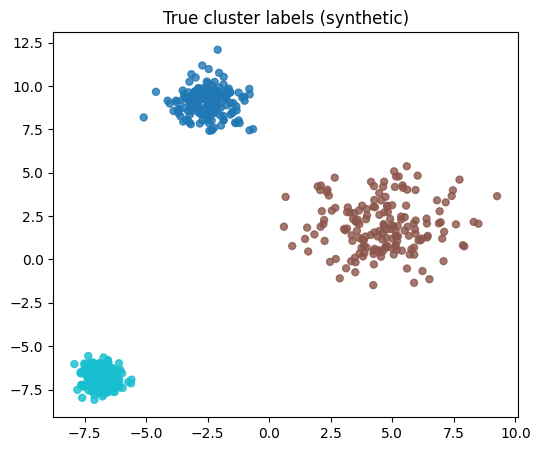

In [33]:
# Cell 4: Create data and show true labels
X, y = make_blobs(n_samples=500, centers=3, cluster_std=[0.8, 1.5, 0.5], random_state=42)
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='tab10', s=25, alpha=0.8)
plt.title('True cluster labels (synthetic)')
plt.show()

## Step 1.5 — Multiple datasets with different cluster separation
We'll create several datasets with varying cluster quality to demonstrate how accuracy differs across metrics when clusters have different geometric properties.

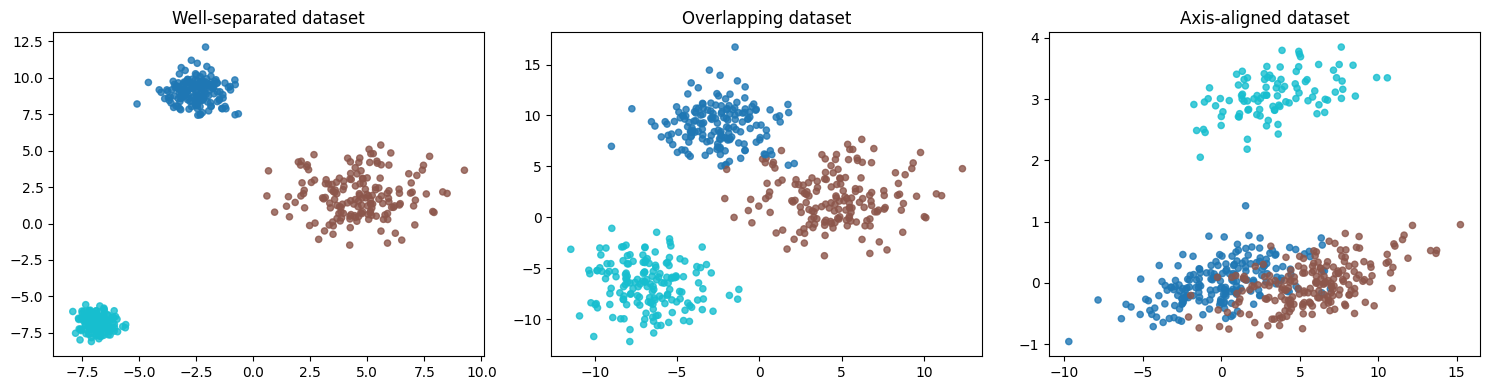

In [29]:
# Multiple datasets with different properties
# Dataset 1: Well-separated (original)
X1, y1 = make_blobs(n_samples=500, centers=3, cluster_std=[0.8, 1.5, 0.5], random_state=42)

# Dataset 2: Overlapping (high noise)
X2, y2 = make_blobs(n_samples=500, centers=3, cluster_std=[2.0, 2.5, 2.2], random_state=42)

# Dataset 3: Axis-aligned elongated (Manhattan-friendly)
np.random.seed(42)
X3_c0 = np.random.randn(200, 2) @ np.array([[3, 0.2], [0, 0.3]]) + np.array([0, 0])
X3_c1 = np.random.randn(200, 2) @ np.array([[3, 0.2], [0, 0.3]]) + np.array([6, 0])
X3_c2 = np.random.randn(100, 2) @ np.array([[3, 0.2], [0, 0.3]]) + np.array([3, 3])
X3 = np.vstack([X3_c0, X3_c1, X3_c2])
y3 = np.hstack([np.zeros(200), np.ones(200), 2*np.ones(100)])

datasets = {
    'Well-separated': (X1, y1),
    'Overlapping': (X2, y2),
    'Axis-aligned': (X3, y3)
}

# Visualize all three datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, (X, y)) in zip(axes, datasets.items()):
    ax.scatter(X[:,0], X[:,1], c=y, cmap='tab10', s=20, alpha=0.8)
    ax.set_title(f'{name} dataset')
plt.tight_layout()
plt.show()

## Step 2 — KMeans implementation that supports multiple distance metrics
We'll implement a small KMeans class that accepts `metric='euclidean'|'manhattan'|'cosine'`.
This keeps the example educational and avoids hidden library internals.

In [30]:
# Cell 6: Custom KMeans implementation
class KMeansCustom:
    def __init__(self, n_clusters=3, metric='euclidean', max_iter=300, tol=1e-4, random_state=None):
        self.k = n_clusters
        self.metric = metric
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = np.random.RandomState(random_state)

    def _distance(self, X, centroids):
        # X: (n_samples, n_features), centroids: (k, n_features) -> return (n_samples, k) distances
        if self.metric == 'euclidean':
            diff = X[:, None, :] - centroids[None, :, :]
            return np.linalg.norm(diff, axis=2)
        if self.metric == 'manhattan':
            diff = np.abs(X[:, None, :] - centroids[None, :, :])
            return np.sum(diff, axis=2)
        if self.metric == 'cosine':
            # cosine distance = 1 - cosine_similarity
            X_norm = np.linalg.norm(X, axis=1, keepdims=True)
            C_norm = np.linalg.norm(centroids, axis=1, keepdims=True)
            Xn = X / np.maximum(X_norm, 1e-12)
            Cn = centroids / np.maximum(C_norm, 1e-12)
            sim = Xn.dot(Cn.T)
            return 1 - sim
        raise ValueError('Unknown metric')

    def fit_predict(self, X):
        n_samples, n_features = X.shape
        init_idx = self.random_state.choice(n_samples, self.k, replace=False)
        centroids = X[init_idx].astype(float)

        if self.metric == 'cosine':
            norms = np.linalg.norm(centroids, axis=1, keepdims=True)
            centroids = centroids / np.maximum(norms, 1e-12)

        for it in range(self.max_iter):
            dists = self._distance(X, centroids)
            labels = np.argmin(dists, axis=1)

            new_centroids = np.zeros_like(centroids)
            for j in range(self.k):
                members = X[labels == j]
                if len(members) == 0:
                    new_centroids[j] = X[self.random_state.randint(0, n_samples)]
                else:
                    new_centroids[j] = members.mean(axis=0)

            if self.metric == 'cosine':
                norms = np.linalg.norm(new_centroids, axis=1, keepdims=True)
                new_centroids = new_centroids / np.maximum(norms, 1e-12)

            shift = np.linalg.norm(new_centroids - centroids)
            centroids = new_centroids
            if shift <= self.tol:
                break

        self.cluster_centers_ = centroids
        self.labels_ = labels
        return labels

def cluster_accuracy_from_labels(true, pred):
    mapping = {}
    for cluster in np.unique(pred):
        members = true[pred == cluster]
        if len(members) == 0:
            mapping[cluster] = -1
        else:
            mapping[cluster] = Counter(members).most_common(1)[0][0]
    mapped = np.vectorize(lambda c: mapping[c])(pred)
    acc = (mapped == true).mean()
    return acc, mapping

## Step 3 — Run K-means with different distance metrics and compare

We run the custom KMeans for `euclidean`, `manhattan`, and `cosine`. For each metric we show a scatter plot colored by predicted cluster, mark centroids, and print ARI and a mapped accuracy.

**Key metrics:**
- **Accuracy (acc)**: Percentage of points assigned to the correct cluster (after mapping predicted clusters to true labels).
- **ARI (Adjusted Rand Index)**: Measures how well predicted clusters match true labels, accounting for random chance. Ranges from -1 (worse than random) to 1 (perfect). Values > 0.9 are considered excellent agreement.

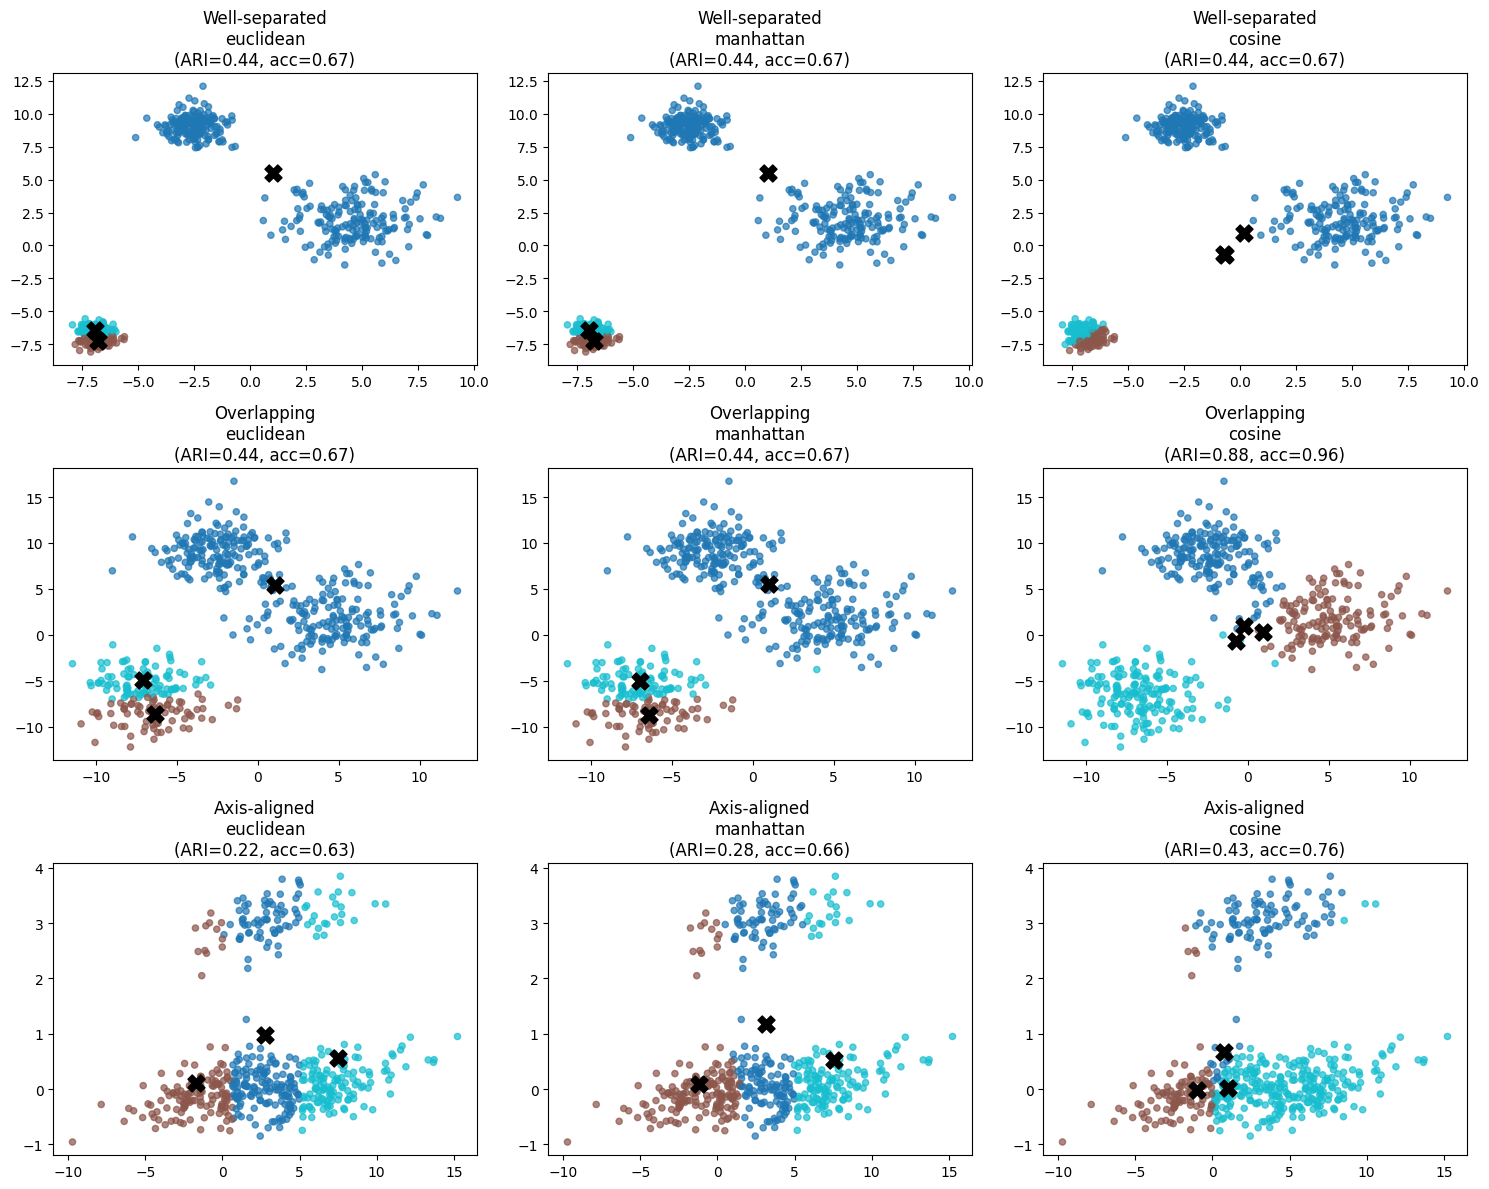


COMPARISON ACROSS DATASETS AND METRICS

Well-separated Dataset:
  euclidean: ARI= 0.444, Accuracy= 0.666, Mapping={0: 1, 1: 2, 2: 2}
  manhattan: ARI= 0.443, Accuracy= 0.666, Mapping={0: 1, 1: 2, 2: 2}
  cosine   : ARI= 0.444, Accuracy= 0.666, Mapping={0: 1, 1: 2, 2: 2}

Overlapping Dataset:
  euclidean: ARI= 0.444, Accuracy= 0.666, Mapping={0: 1, 1: 2, 2: 2}
  manhattan: ARI= 0.443, Accuracy= 0.666, Mapping={0: 0, 1: 2, 2: 2}
  cosine   : ARI= 0.881, Accuracy= 0.958, Mapping={0: 0, 1: 1, 2: 2}

Axis-aligned Dataset:
  euclidean: ARI= 0.225, Accuracy= 0.628, Mapping={0: 0.0, 1: 0.0, 2: 1.0}
  manhattan: ARI= 0.282, Accuracy= 0.660, Mapping={0: 2.0, 1: 0.0, 2: 1.0}
  cosine   : ARI= 0.426, Accuracy= 0.760, Mapping={0: 2.0, 1: 0.0, 2: 1.0}


In [34]:
# Run K-means on all three datasets with all three metrics
results = {}
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for row, (dataset_name, (X, y)) in enumerate(datasets.items()):
    for col, metric in enumerate(['euclidean', 'manhattan', 'cosine']):
        km = KMeansCustom(n_clusters=3, metric=metric, random_state=42)
        labels = km.fit_predict(X)
        ari = adjusted_rand_score(y, labels)
        acc, mapping = cluster_accuracy_from_labels(y, labels)
        
        # Store results
        if dataset_name not in results:
            results[dataset_name] = {}
        results[dataset_name][metric] = {'ari': ari, 'acc': acc, 'mapping': mapping}
        
        # Plot
        ax = axes[row, col]
        ax.scatter(X[:,0], X[:,1], c=labels, cmap='tab10', s=20, alpha=0.7)
        centroids = km.cluster_centers_
        ax.scatter(centroids[:,0], centroids[:,1], marker='X', s=150, c='k')
        ax.set_title(f"{dataset_name}\n{metric}\n(ARI={ari:.2f}, acc={acc:.2f})")

plt.tight_layout()
plt.show()

# Print detailed results table
print("\n" + "="*70)
print("COMPARISON ACROSS DATASETS AND METRICS")
print("="*70)
for dataset_name in datasets.keys():
    print(f"\n{dataset_name} Dataset:")
    for metric in ['euclidean', 'manhattan', 'cosine']:
        ari = results[dataset_name][metric]['ari']
        acc = results[dataset_name][metric]['acc']
        mapping = results[dataset_name][metric]['mapping']
        print(f"  {metric:9s}: ARI={ari:6.3f}, Accuracy={acc:6.3f}, Mapping={mapping}")

## Notes and next steps
- Euclidean distance is the standard for K-means (minimizes squared euclidean).
- Manhattan can behave differently when clusters are elongated along axes.
- Cosine ignores magnitude and groups by angle; useful for directional data.

Possible extensions: add kmeans++ initialization, try high-dimensional data, or compare with scikit-learn's `KMeans` for speed.

## Step 4 — Compute clustering error for each metric
We'll compute three error measures aligned with the distance metric used:
- Euclidean: inertia (sum of squared euclidean distances to centroids).
- Manhattan: sum of L1 distances to centroids.
- Cosine: sum of cosine distances (1 - cosine_similarity) to centroids.
These help quantify how well clusters group around their centroids under each metric.

In [32]:
# Cell: compute errors per metric
def compute_errors(X, labels, centroids, metric='euclidean'):
    # X: (n, d), labels: (n,), centroids: (k, d)
    errors = []
    for i, x in enumerate(X):
        c = centroids[labels[i]]
        if metric == 'euclidean':
            # squared euclidean distance (inertia contribution)
            err = np.sum((x - c)**2)
        elif metric == 'manhattan':
            err = np.sum(np.abs(x - c))
        elif metric == 'cosine':
            # cosine distance = 1 - cosine_similarity
            xn = x / max(np.linalg.norm(x), 1e-12)
            cn = c / max(np.linalg.norm(c), 1e-12)
            err = 1 - np.dot(xn, cn)
        else:
            raise ValueError('unknown metric')
        errors.append(err)
    errors = np.array(errors)
    return errors, errors.mean(), errors.sum()

# compute and print errors for each metric using the models we ran earlier
for metric in ['euclidean', 'manhattan', 'cosine']:
    km = KMeansCustom(n_clusters=3, metric=metric, random_state=42)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_
    errs, mean_err, total_err = compute_errors(X, labels, centroids, metric=metric)
    if metric == 'euclidean':
        print(f"{metric:9s}: mean squared error={mean_err:.4f}, inertia(sum sq)={total_err:.4f}")
    elif metric == 'manhattan':
        print(f"{metric:9s}: mean L1 error={mean_err:.4f}, total L1={total_err:.4f}")
    else:
        print(f"{metric:9s}: mean cosine-dist={mean_err:.4f}, total cosine-dist={total_err:.4f}")

euclidean: mean squared error=4.2615, inertia(sum sq)=2130.7312
manhattan: mean L1 error=2.2250, total L1=1112.4849
cosine   : mean cosine-dist=0.0499, total cosine-dist=24.9257


### Interpretation and tips
- Lower error under the same metric means points are closer to their centroids under that metric's geometry.
- Euclidean inertia is commonly used to pick `k` via the elbow method.
- For sparse or high-dimensional directional data (e.g., TF-IDF vectors), cosine is often more meaningful.
- When comparing metrics, make sure the error you compute matches the metric geometry (we used squared for euclidean, L1 for manhattan, and cosine-dist for cosine).